In [1]:
%matplotlib notebook
from hamiltonian.games import StochasticBilinearGame, GaussianBilinearGame, QuadraticGame, BilinearGame
from hamiltonian.games.utils import make_sym_matrix
from hamiltonian.algorithms import ConsensusOptimization, SVRCO, SEG
from hamiltonian.algorithms.lr_scheduler import DecreasingLR, LRScheduler
import torch
import matplotlib.pyplot as plt
import numpy as np
import time
import math

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"],
    'font.size'   : 10})

In [2]:
class SEGScheduler(LRScheduler):
    def __init__(self, K, rho, lr):
        super().__init__(lr)
        self.K = K
        self.rho = rho
        self.k_0 = math.ceil(self.K/2)
        
    def __call__(self, k, index=None):
        if self.K <= 1/self.rho or (self.K > 1/self.rho and k <= self.k_0):
            beta = 1
        else:
            beta = 2/(2 + self.rho*(k - self.k_0))
            
        return self.lr*beta
    
class OldSEGScheduler(LRScheduler):
    def __init__(self, K, L, mu, coeff=1.):
        super().__init__(lr=None)
        self.K = K
        self.L = L
        self.mu = mu
        self.coeff = coeff
        self.threshold = 8*L/mu
        self.k_0 = math.ceil(self.K/2)
        
    def __call__(self, k, index=None):
        if self.K <= self.threshold or (self.K > self.threshold and k <= self.k_0):
            gamma = 1/(4*self.L)
        else:
            gamma = 4/(16*self.L + self.mu*(k-self.k_0))
        return self.coeff*gamma
        
        
class HsiehScheduler(LRScheduler):
    def __init__(self, L, mu, nu, coeff=1.):
        lr = math.sqrt(2)/(3*game.mu)
        super().__init__(lr=lr)
        self.nu = nu
        self.coeff = coeff
        self.b = (2*L/(3*mu))**3
        
    def __call__(self, k, index=None):
        return self.coeff*self.lr/(k + self.b)**self.nu

# Quadratic Game

## Same sample

/private/home/hberard/Projects/momentum-hamiltonian/hamiltonian/games/utils.py:19: UserWarning: torch.qr is deprecated in favor of torch.linalg.qr and will be removed in a future PyTorch release.
The boolean parameter 'some' has been replaced with a string parameter 'mode'.
Q, R = torch.qr(A, some)
should be replaced with
Q, R = torch.linalg.qr(A, 'reduced' if some else 'complete') (Triggered internally at  /pytorch/aten/src/ATen/native/BatchLinearAlgebra.cpp:1940.)
  Q, _ = torch.qr(A)


-0.5561845302581787 0.5561845302581787


<IPython.core.display.Javascript object>


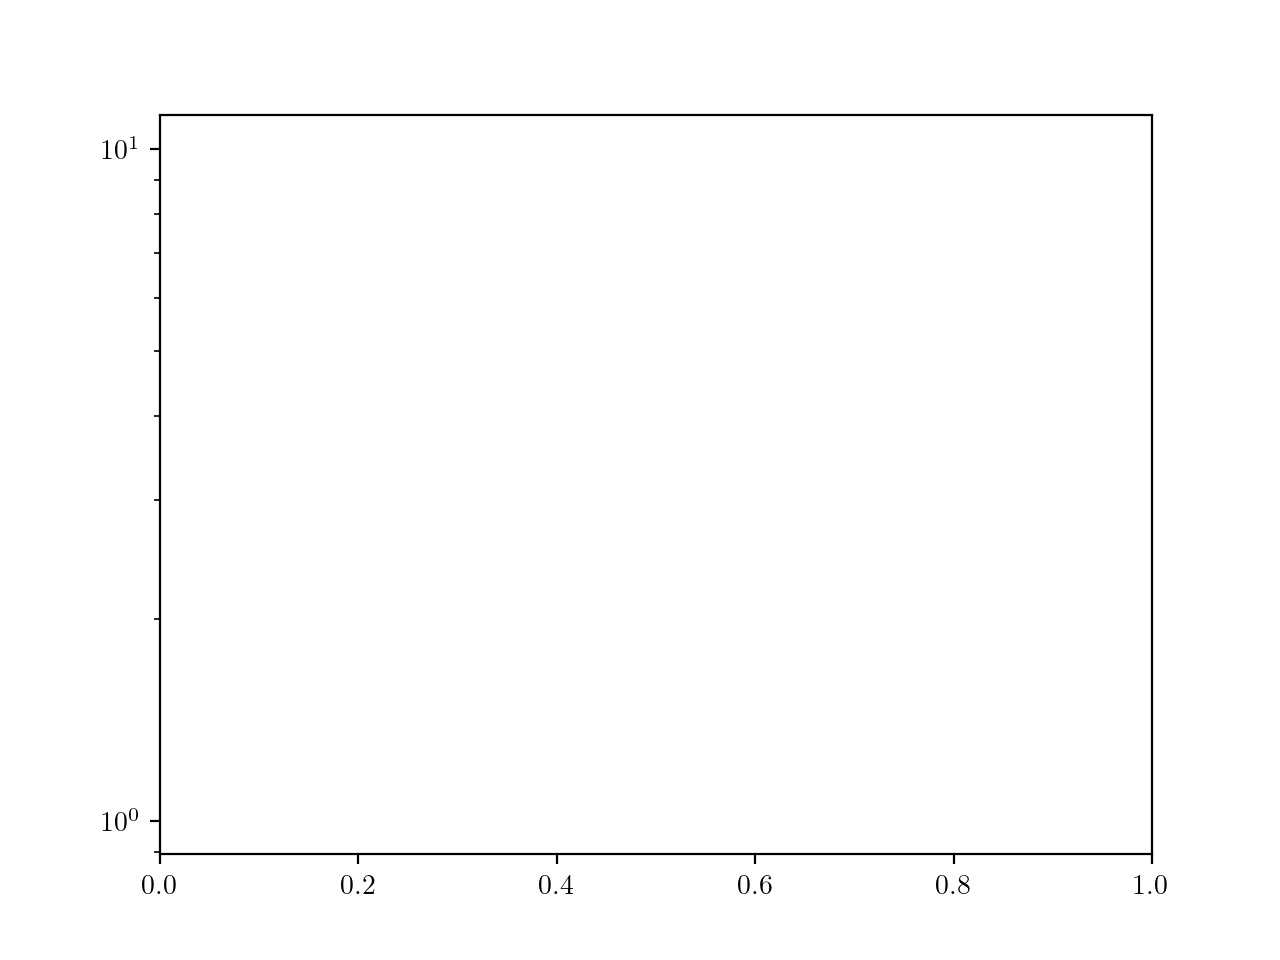

In [3]:
K = 1000
game = QuadraticGame(100, 100, mu=1e-1, L=1, bias=True)
print(game.imag_min, game.imag_max)
fig = plt.figure()
plt.yscale("log")

In [36]:
gamma_1 = 1/game.L_max
gamma_2 = gamma_1/4
for alpha in [1/6, 1/10, 1/100]:
    alg = SEG(game, lr=alpha*gamma_2, lr_e=alpha*gamma_1, same_sample=True, full_batch=False)
    results = alg.run(K)
    plt.plot(results["dist2opt"], label="Ours S-SEG constant step-size $\gamma/%i$ (Theorem 3.7)"%(int(1/alpha)))

In [37]:
rho = game.mu_mean/(48*game.L_max)
lr = 1/(6*game.L_max)
gamma_1 = SEGScheduler(K, rho, lr)
gamma_2 = SEGScheduler(K, rho, lr/4)
print(1/rho)
alg = SEG(game, lr=gamma_2, lr_e=gamma_1, same_sample=True, full_batch=False)
results = alg.run(K)
plt.plot(results["dist2opt"], label="S-SEG decreasing step-size (new version)")

216.74475720292017


In [29]:
gamma_1 = OldSEGScheduler(K, game.L_max, game.mu_min)
gamma_2 = OldSEGScheduler(K, game.L_max, game.mu_min, coeff=1/4)
alg = SEG(game, lr=gamma_2, lr_e=gamma_1, same_sample=True, full_batch=False)
results = alg.run(K)
plt.plot(results["dist2opt"], label="S-SEG decreasing step-size (old version)")

In [4]:
gamma = 1/(game.L_max)
for lr in [1/2, 1/10, 1/100]:
    alg = SEG(game, lr=gamma*lr, lr_e=gamma*lr, same_sample=True, full_batch=False)
    results = alg.run(K)
    plt.plot(results["dist2opt"], label="Konstantin S-SEG $\gamma=1/%iL$ (Theorem 2)"%(int(1/lr)))

In [30]:
plt.legend()

## Independent sample

<IPython.core.display.Javascript object>


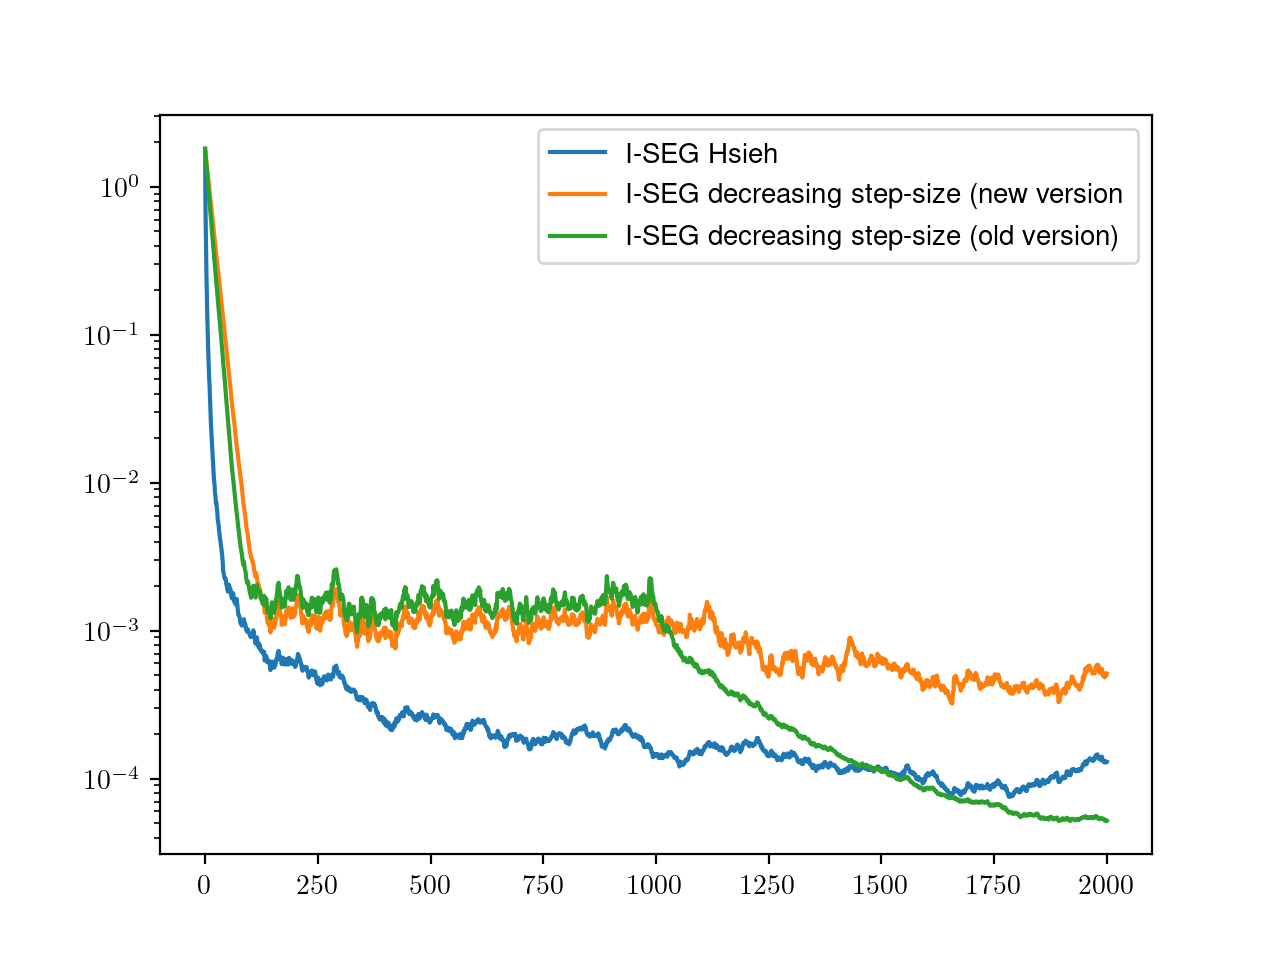

In [13]:
K=2000
fig = plt.figure()
plt.yscale("log")

In [7]:
gamma_1 = 1/(4*game.mu + math.sqrt(6*game.L**2))
gamma_2 = gamma_1/4
alg = SEG(game, lr=gamma_2, lr_e=gamma_1, same_sample=False, full_batch=False)
results = alg.run(K)
plt.plot(results["dist2opt"], label="Ours I-SEG constant step-size (Theorem 3.14)")

In [15]:
gamma = 1/(4*game.mu + math.sqrt(6*game.L**2))
rho = gamma*game.mu/32
gamma_1 = SEGScheduler(K, rho, gamma)
gamma_2 = SEGScheduler(K, rho, gamma/4)
print(1/rho)
alg = SEG(game, lr=gamma_2, lr_e=gamma_1, same_sample=False, full_batch=False)
results = alg.run(K)
plt.plot(results["dist2opt"], label="I-SEG decreasing step-size (new version")

246.28976189614872


In [16]:
gamma_1 = OldSEGScheduler(K, game.L, game.mu)
gamma_2 = OldSEGScheduler(K, game.L, game.mu, coeff=1/4)
alg = SEG(game, lr=gamma_2, lr_e=gamma_1, same_sample=False, full_batch=False)
results = alg.run(K)
plt.plot(results["dist2opt"], label="I-SEG decreasing step-size (old version)")

In [112]:
gamma = 1/game.L
for lr in [1/4, 1/10, 1/100]:
    alg = SEG(game, lr=gamma*lr, lr_e=gamma*lr, same_sample=False, full_batch=False)
    results = alg.run(K)
    plt.plot(results["dist2opt"], label="Aleksandr I-SEG $\gamma=1/%iL$ (Theorem 5)"%(int(1/lr)))

In [14]:
nu = 2/3
lr_e = HsiehScheduler(game.L, game.mu, nu=1-nu)
lr = HsiehScheduler(game.L, game.mu, nu=nu)
alg = SEG(game, lr=lr, lr_e=lr_e, same_sample=False, full_batch=False)
results = alg.run(K)
plt.plot(results["dist2opt"], label="I-SEG Hsieh")

In [17]:
plt.legend()

## S-SEG US vs IS

0.8836519718170166 0.576364278793335 0.1500217318534851 10.093368530273438 tensor([ 1.4232,  1.3229,  1.3184,  1.3281,  1.3054,  1.3359,  1.3534,  1.3362,
         1.3268,  1.3471,  1.3252,  1.3310,  1.3372,  1.3509,  1.3298,  1.3379,
         1.3195,  1.3593,  1.3244,  1.3141,  1.3205,  1.3306,  1.3448,  1.3390,
         1.3858,  1.3385,  1.3070,  1.3640,  1.3554,  1.3821,  1.3357,  1.3344,
         1.3723,  1.3296,  1.3470,  1.3468,  1.3190,  1.3446,  1.3282,  1.3556,
         1.3488,  1.3302,  1.3336,  1.3647,  1.3197,  1.3145,  1.3409,  1.3206,
         1.3469,  1.3390,  1.3194,  1.3455,  1.3229,  1.3090,  1.3331,  1.3261,
         1.3285,  1.3314,  1.3312,  1.3009,  1.4650,  1.3385,  1.3385,  1.3421,
         1.3300,  1.3550,  1.3290,  1.3479,  1.3420,  1.3472,  1.4208,  1.3038,
         1.3716,  1.2991,  1.3391,  1.3284,  1.3284,  1.3073,  1.3141,  1.3299,
         1.3267,  1.3468,  1.3057,  1.3324,  1.3212,  1.3752,  1.3397,  1.3298,
         1.3438,  1.3605,  1.3277,  1.3927,  

<IPython.core.display.Javascript object>


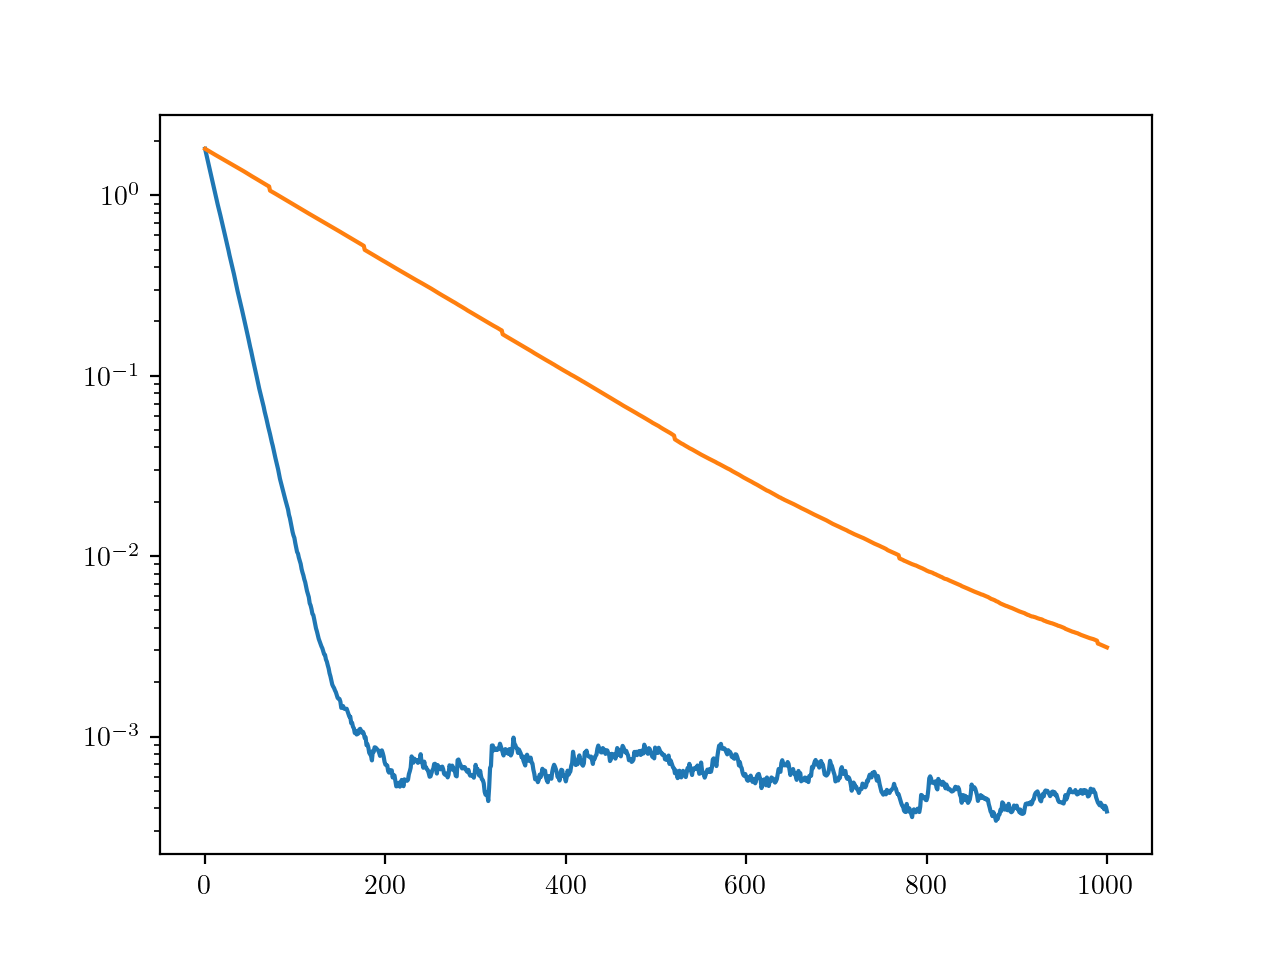

In [22]:
mu = 1e-1
dim = 100
A_0 = make_sym_matrix(dim - 1, dim, 1e-1, 1)
A_1 = make_sym_matrix(1, dim, 10, 10)
A = torch.cat([A_0, A_1], dim=0)
game = QuadraticGame(dim, dim, mu=1e-1, L=1, bias=True, A=A)
print(game.L, game.mu, game.mu_min, game.L_max, game.L_i, game.L_mean)

fig = plt.figure()
plt.yscale("log")

In [23]:
class SameSEGScheduler(LRScheduler):
    def __init__(self, K, mu, L_i, coeff=1.):
        self.L_i = L_i
        self.L_mean = L_i.mean().item()
        lr = 1/(4*self.L_mean)
        super().__init__(lr)
        self.K = K
        self.threshold = 32*self.L_mean/mu  
        self.mu = mu
        self.coeff = coeff
        self.k_0 = math.ceil(self.K/2)
        
    def __call__(self, k, index):
        if self.K <= self.threshold or (self.K > self.threshold and k <= self.k_0):
            a = 1/4
        else:
            a = 16*self.L_mean/(64*self.L_mean + self.mu*(k - self.k_0))
            
        return self.coeff*a/self.L_i[index]
        
gamma_1 = SameSEGScheduler(1000, game.mu_min, game.L_i)
gamma_2 = SameSEGScheduler(1000, game.mu_min, game.L_i, coeff=1/4)
print(gamma_1.threshold, game.L_i)
alg = SEG(game, lr=gamma_2, lr_e=gamma_1, same_sample=True, full_batch=False)
results = alg.run(1000)
plt.plot(results["dist2opt"], label="Ours S-SEG-IS")

304.30695600662233 tensor([ 1.4232,  1.3229,  1.3184,  1.3281,  1.3054,  1.3359,  1.3534,  1.3362,
         1.3268,  1.3471,  1.3252,  1.3310,  1.3372,  1.3509,  1.3298,  1.3379,
         1.3195,  1.3593,  1.3244,  1.3141,  1.3205,  1.3306,  1.3448,  1.3390,
         1.3858,  1.3385,  1.3070,  1.3640,  1.3554,  1.3821,  1.3357,  1.3344,
         1.3723,  1.3296,  1.3470,  1.3468,  1.3190,  1.3446,  1.3282,  1.3556,
         1.3488,  1.3302,  1.3336,  1.3647,  1.3197,  1.3145,  1.3409,  1.3206,
         1.3469,  1.3390,  1.3194,  1.3455,  1.3229,  1.3090,  1.3331,  1.3261,
         1.3285,  1.3314,  1.3312,  1.3009,  1.4650,  1.3385,  1.3385,  1.3421,
         1.3300,  1.3550,  1.3290,  1.3479,  1.3420,  1.3472,  1.4208,  1.3038,
         1.3716,  1.2991,  1.3391,  1.3284,  1.3284,  1.3073,  1.3141,  1.3299,
         1.3267,  1.3468,  1.3057,  1.3324,  1.3212,  1.3752,  1.3397,  1.3298,
         1.3438,  1.3605,  1.3277,  1.3927,  1.3103,  1.3274,  1.3468,  1.3389,
         1.3345,  1.3

In [24]:
class SameSEGScheduler(LRScheduler):
    def __init__(self, K, mu, L, coeff=1.):
        lr = 1/(4*L)
        super().__init__(lr)
        self.K = K
        self.threshold = 8*L/mu
        self.L = L
        self.mu = mu
        self.coeff = coeff
        self.k_0 = math.ceil(self.K/2)
        
    def __call__(self, k, index=None):
        if self.K <= self.threshold or (self.K > self.threshold and k <= self.k_0):
            return self.coeff*1/(4*self.L)
        else:
            return self.coeff*4/(16*self.L + self.mu*(k - self.k_0))
        
gamma_1 = SameSEGScheduler(1000, game.mu_min, game.L_max)
gamma_2 = SameSEGScheduler(1000, game.mu_min, game.L_max, coeff=1/4)
print(gamma_1.threshold)
alg = SEG(game, lr=gamma_2, lr_e=gamma_1, same_sample=True, full_batch=False)
results = alg.run(1000)
plt.plot(results["dist2opt"], label="Ours S-SEG-US")

538.2350093188295


In [21]:
plt.legend()

## $\mu_i$ negative

0.8015287518501282 0.5256805419921875 -0.09932868927717209 0.3133646845817566 1.5138959884643555 1.340850830078125


<IPython.core.display.Javascript object>


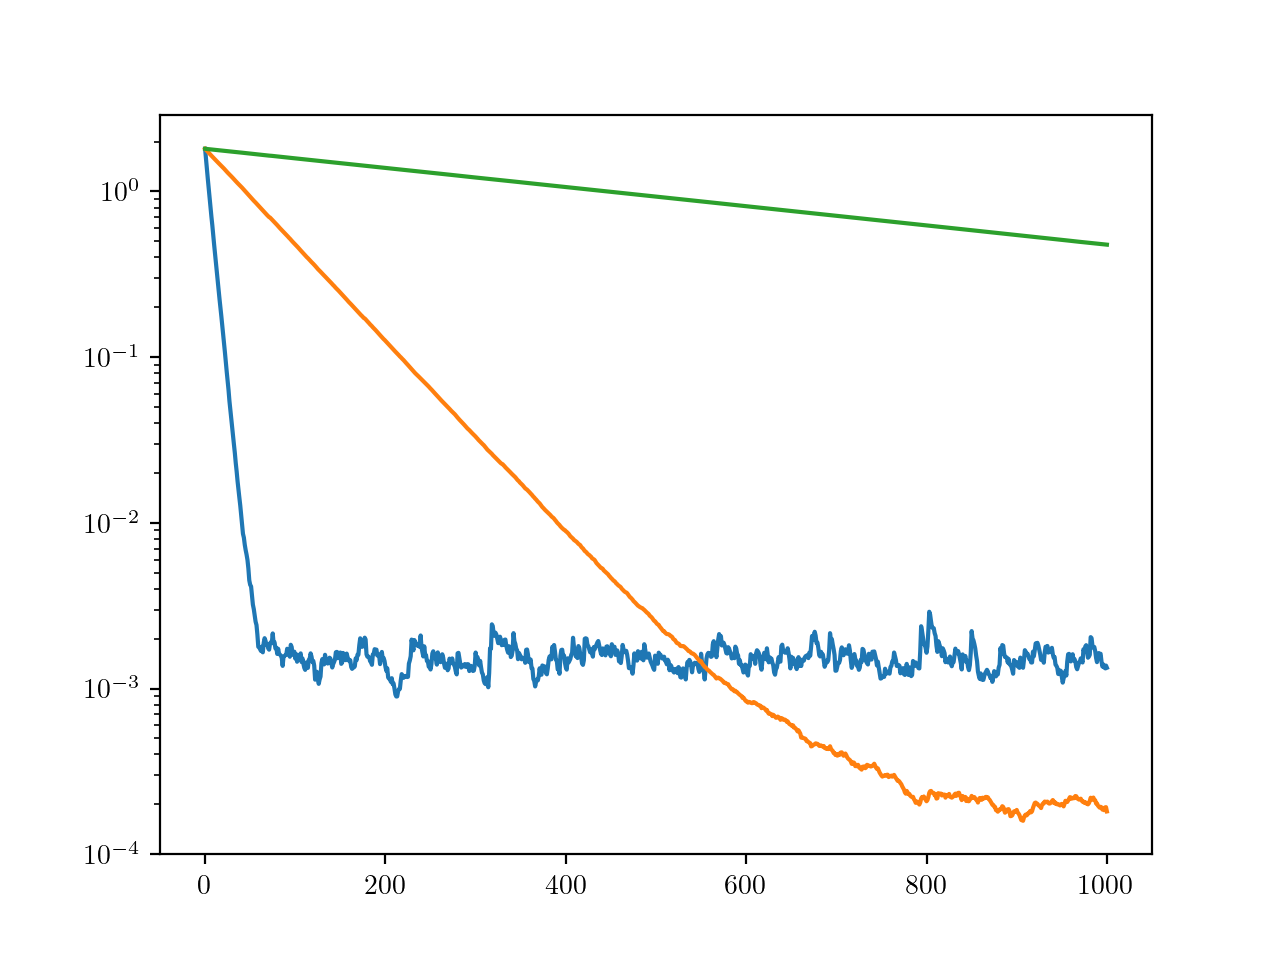

In [25]:
dim = 100
K=1000
A_0 = make_sym_matrix(dim - 1, dim, 1e-1, 1)
A_1 = make_sym_matrix(1, dim, -1e-1, -1e-1)
A = torch.cat([A_0, A_1], dim=0)
game = QuadraticGame(dim, dim, mu=1e-1, L=1, bias=True, A=A)
print(game.L, game.mu, game.mu_min, game.mu_mean, game.L_max, game.L_mean)

fig = plt.figure()
plt.yscale("log")

In [26]:
gamma_1 = max(1/(math.sqrt(2)*game.L_max), (-game.mu_min + math.sqrt(game.mu_min**2 + 2*game.L_max**2))/(2*game.L_max**2))
gamma_2 = gamma_1/4
for alpha in [1, 1/10, 1/100]:
    alg = SEG(game, lr=alpha*gamma_2, lr_e=alpha*gamma_1, same_sample=True, full_batch=False)
    results = alg.run(K)
    plt.plot(results["dist2opt"], label="Ours S-SEG constant step-size $\gamma/%i$ (Theorem 3.7)"%(int(1/alpha)))

In [19]:
# Gradient Descent
lr_list = [1e0, 5e-1, 1e-1]
for lr in lr_list:
    alg = SEG(game, lr=lr, same_sample=False, full_batch=False)
    print(alg.lr, alg.lr_e)
    results = alg.run(200)
    plt.plot(results["dist2opt"], color="tab:orange", alpha=lr, label="SEG $\gamma_1=\gamma_2=%.1f$"%lr)

[lr=1.0e+00, lr=1.0e+00] [lr=1.0e+00, lr=1.0e+00]
[lr=5.0e-01, lr=5.0e-01] [lr=5.0e-01, lr=5.0e-01]
[lr=1.0e-01, lr=1.0e-01] [lr=1.0e-01, lr=1.0e-01]


In [6]:
plt.legend()

# TESTS

In [10]:
lr = 0
lr_H = 1/(2*game.L_H)
alg = ConsensusOptimization(game, lr=lr, lr_H=lr_H, full_batch=False)
t = time.time()
results = alg.run(100)
plt.plot(results["dist2opt"], label="SCO")

In [136]:
plt.legend()
#plt.xlim(0, 20)

### Decreasing step size

<IPython.core.display.Javascript object>


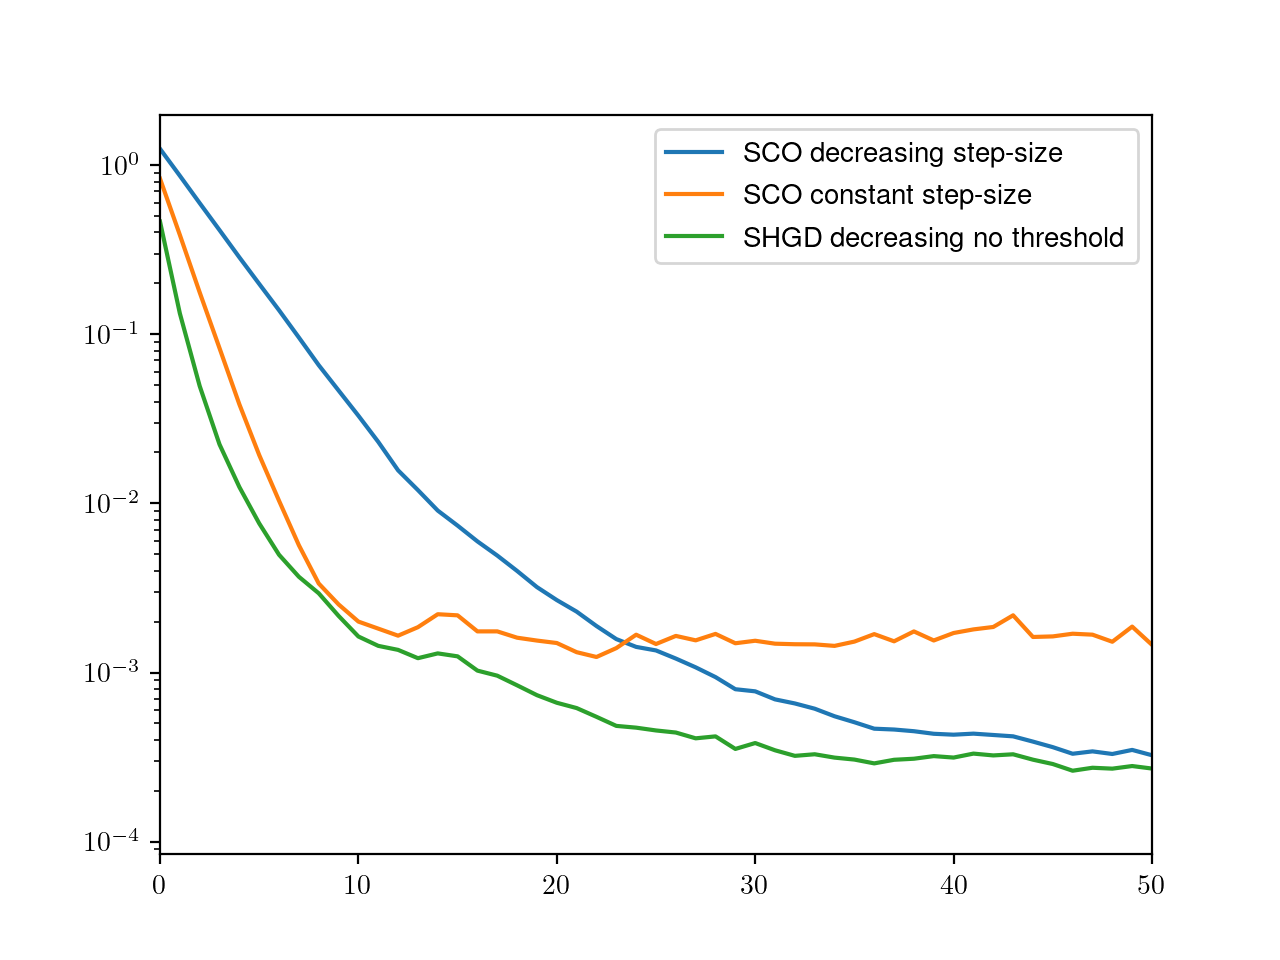

0.5 2.5000005215407506 1.118032455444336 1.1180349588394165


In [46]:
dim = 100
game = QuadraticGame(dim, dim, mu=2e-1, L=2e-1, mu_B=1, L_B=1, bias=True, normal=True)
fig = plt.figure()
plt.yscale("log")
print(game.mu, game.ell, game.mu_H, game.L_H)

In [47]:
# Gradient Descent
lr = SCOScheduler(phi=max(game.ell, game.L_H), mu=game.mu+game.mu_H)
alg = ConsensusOptimization(game, lr=lr, lr_H=lr, full_batch=False)
t = time.time()
results = alg.run(100)
plt.plot(results["dist2opt"], label="SCO decreasing step-size")

In [48]:
lr = 1/(4*game.ell)
lr_H = 1/(4*game.L_H)
alg = ConsensusOptimization(game, lr=lr, lr_H=lr_H, full_batch=False)
t = time.time()
results = alg.run(100)
plt.plot(results["dist2opt"], label="SCO constant step-size")

In [49]:
# Gradient Descent
lr = SCOScheduler(phi=max(game.ell, game.L_H), mu=game.mu+game.mu_H)
lr.k = 0
alg = ConsensusOptimization(game, lr=lr, lr_H=lr, full_batch=False)
t = time.time()
results = alg.run(100)
plt.plot(results["dist2opt"], label="SCO decreasing no threshold")

In [52]:
plt.xlim(0, 50)
plt.legend()

In [9]:
# Gradient Descent
lr = SCOScheduler(phi=max(game.ell, game.L_H), mu=game.mu+game.mu_H)
alg = ConsensusOptimization(game, lr=lr, lr_H=lr, full_batch=False)
t = time.time()
results = alg.run(1000)
plt.plot(results["dist2opt"], label="SHGD")

### Optimal mini-batch size

<IPython.core.display.Javascript object>


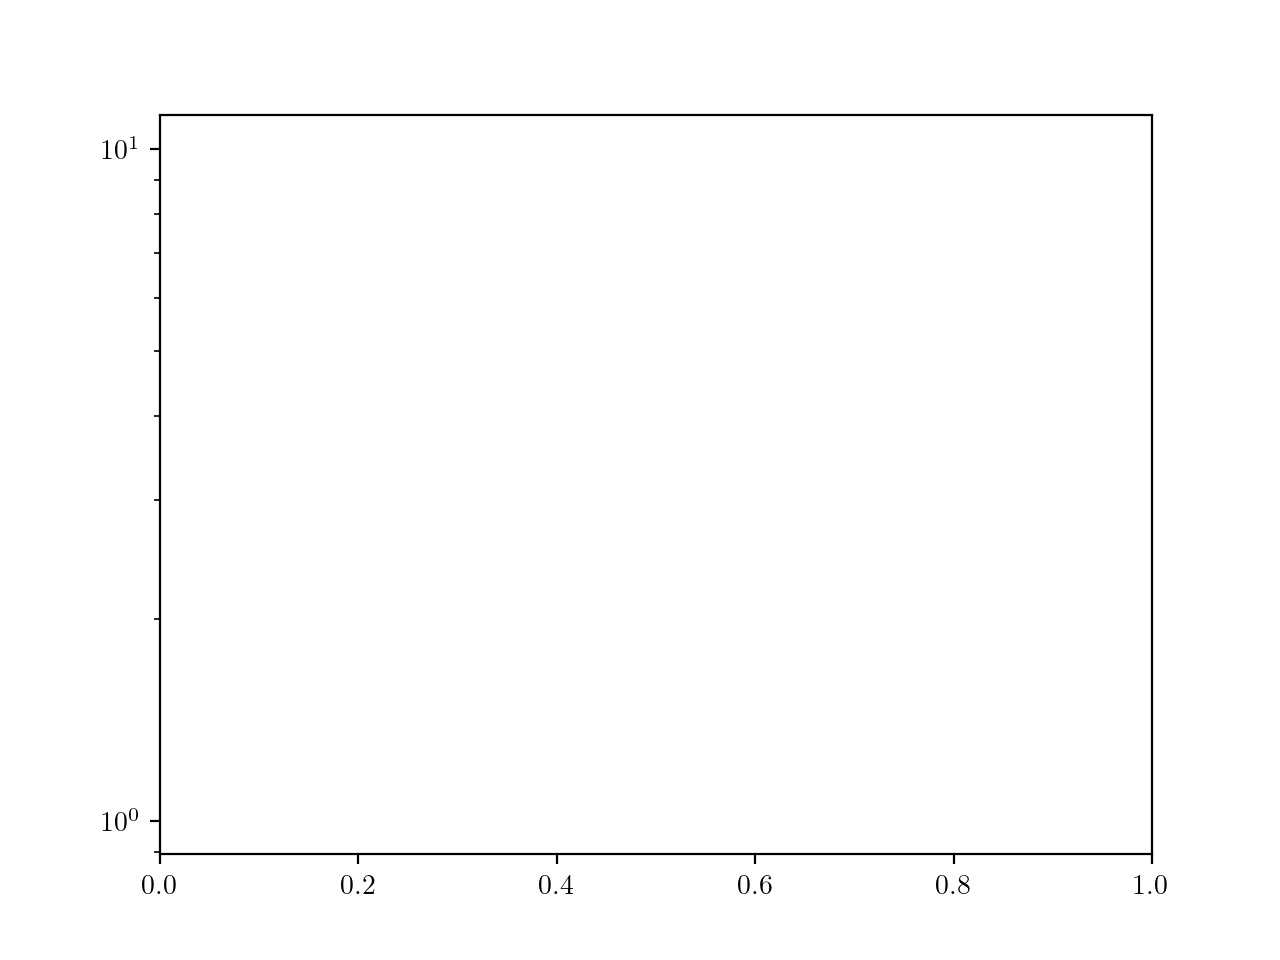

0.08196698874235153 4.7463555335998535 0.6410531401634216 0.7540459632873535 1.0401451038606575


In [36]:
dim = 10
game = QuadraticGame(dim, 100, mu=1e-4, L=1, mu_B=1e-4, L_B=1, bias=True, normal=True)
fig = plt.figure()
plt.yscale("log")
print(game.mu, game.ell, game.mu_H, game.L_H, game.ell_mean)

In [37]:
eps = 1e-6
z1 = float(game.grad_at_optimum())
a = - game.ell + 2/(eps*game.mu)*z1
batch_size = round(game.num_samples*(game.ell_mean + a)/(game.num_samples*game.ell_mean + a))
print((game.ell_mean + a)/(game.num_samples*game.ell_mean + a), batch_size)
z = 1/batch_size * (game.num_samples - batch_size)/(game.num_samples - 1)*z1
print(z)
lr = min(1/(2*game.ell), eps*game.mu/(4*z))
alg = ConsensusOptimization(game, lr=lr, lr_H=0, batch_size=batch_size, full_batch=False)
t = time.time()
results = alg.run(100)
plt.plot(results["dist2opt"], label="SGDA")

0.9999979192578792 100
0.0


ZeroDivisionError: float division by zero

# Heatmap

In [5]:
from matplotlib.colors import LogNorm

<IPython.core.display.Javascript object>


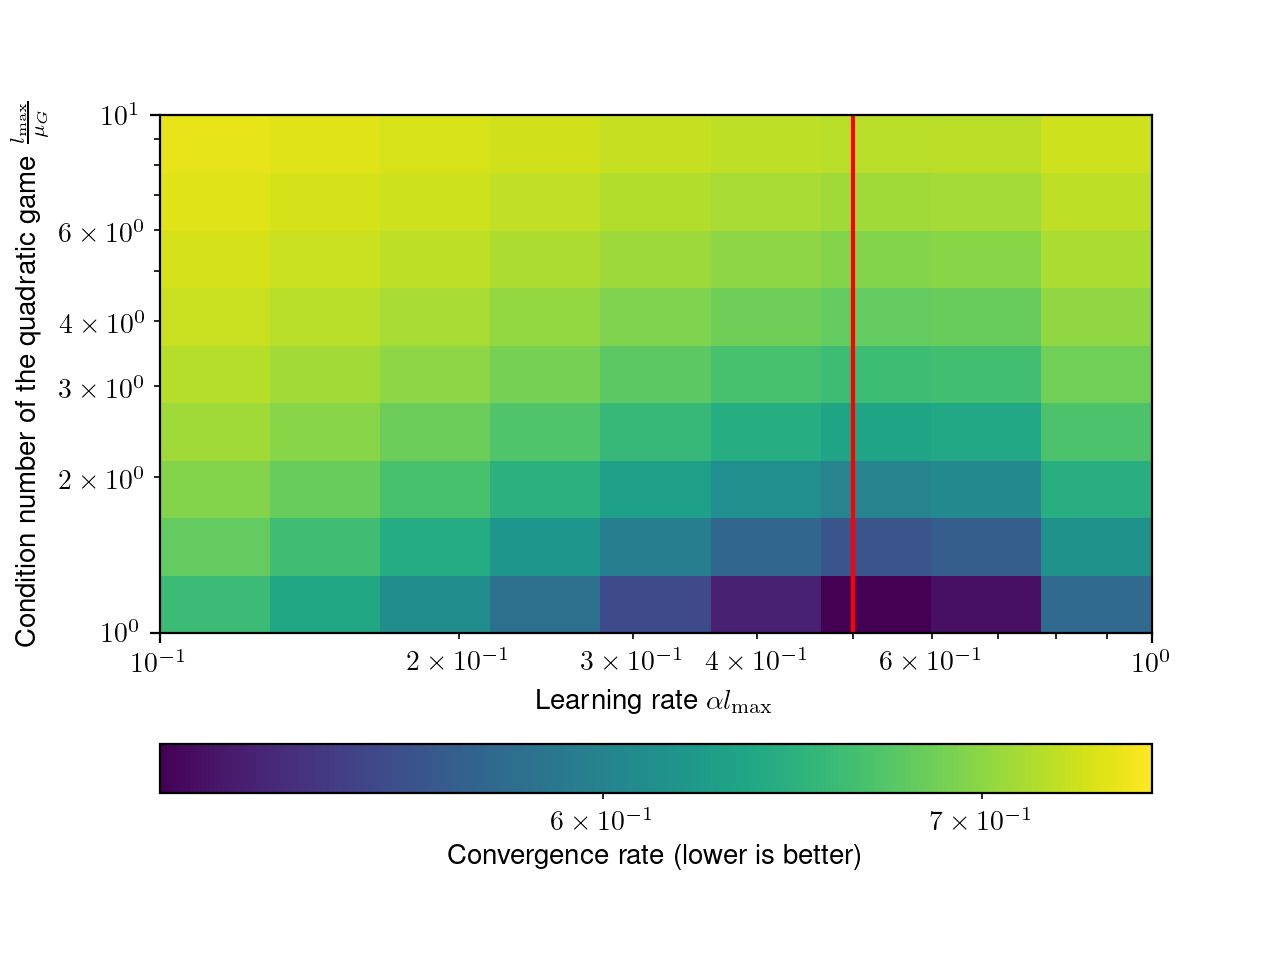

/private/home/hberard/.conda/envs/dev/lib/python3.7/site-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  


In [7]:
alpha = np.logspace(-1, 0, 10)
kappa_G = np.logspace(0, 1, 10)
kappa_H = 1
_alpha, _kappa_G = np.meshgrid(alpha, kappa_G)
Z = (1 - 1/(4*kappa_H) - _alpha/_kappa_G + _alpha**2/_kappa_G)
#Z = Z.clip(1e-1)
fig, ax = plt.subplots(1,1)
c = ax.pcolormesh(_alpha, _kappa_G, Z, norm=LogNorm(vmin=Z.min(), vmax=Z.max()))
cbar = fig.colorbar(c, ax=ax, orientation="horizontal")
cbar.set_label('Convergence rate (lower is better)')
ax.vlines(x=0.5, ymin=1, ymax=10, color="red")
plt.xscale("log")
plt.yscale("log")
plt.xlabel(r"Learning rate $\alpha l_{\max}$")
plt.ylabel(r"Condition number of the quadratic game $\frac{l_{\max}}{\mu_G}$")
plt.savefig("figures/heatmap.pdf", format='pdf', bbox_inches='tight')

# 2D trajectory plots

In [2]:
def plot_grad(game, grid=((-1, 1), (-1, 1))):
    x = torch.linspace(grid[0][0], grid[0][1], 10)
    y = torch.linspace(grid[1][0], grid[1][1], 10)
    grid_x, grid_y = torch.meshgrid(x, y)
    grid_x = grid_x.contiguous().view(-1)
    grid_y = grid_y.contiguous().view(-1)
    grad = []
    for x, y in zip(grid_x, grid_y):
        game.players[0][0].data = x
        game.players[1][0].data = y
        g = game.grad()
        grad.append((g[0], g[1]))
    grad = -torch.tensor(grad)
    plt.quiver(grid_x, grid_y, grad[:,0], grad[:,1], units='width',color='tab:gray', width=0.002)
    plt.scatter(game.x_star, game.y_star, color="black", marker="*", s=300, label="Equilibrium $x^*$", zorder=100)
    plt.xlim(grid[0])
    plt.ylim(grid[1])
    
def init_func(players):
    players[0][0].data = torch.Tensor([0.5])
    players[1][0].data = torch.Tensor([0.5])

    

## Small $\kappa_G$

1.0 2.0 1.4142135381698608 1.4142135381698608


/private/home/hberard/.conda/envs/dev/lib/python3.7/site-packages/torch/nn/modules/container.py:434: UserWarning: Setting attributes on ParameterList is not supported.
  warnings.warn("Setting attributes on ParameterList is not supported.")


<IPython.core.display.Javascript object>


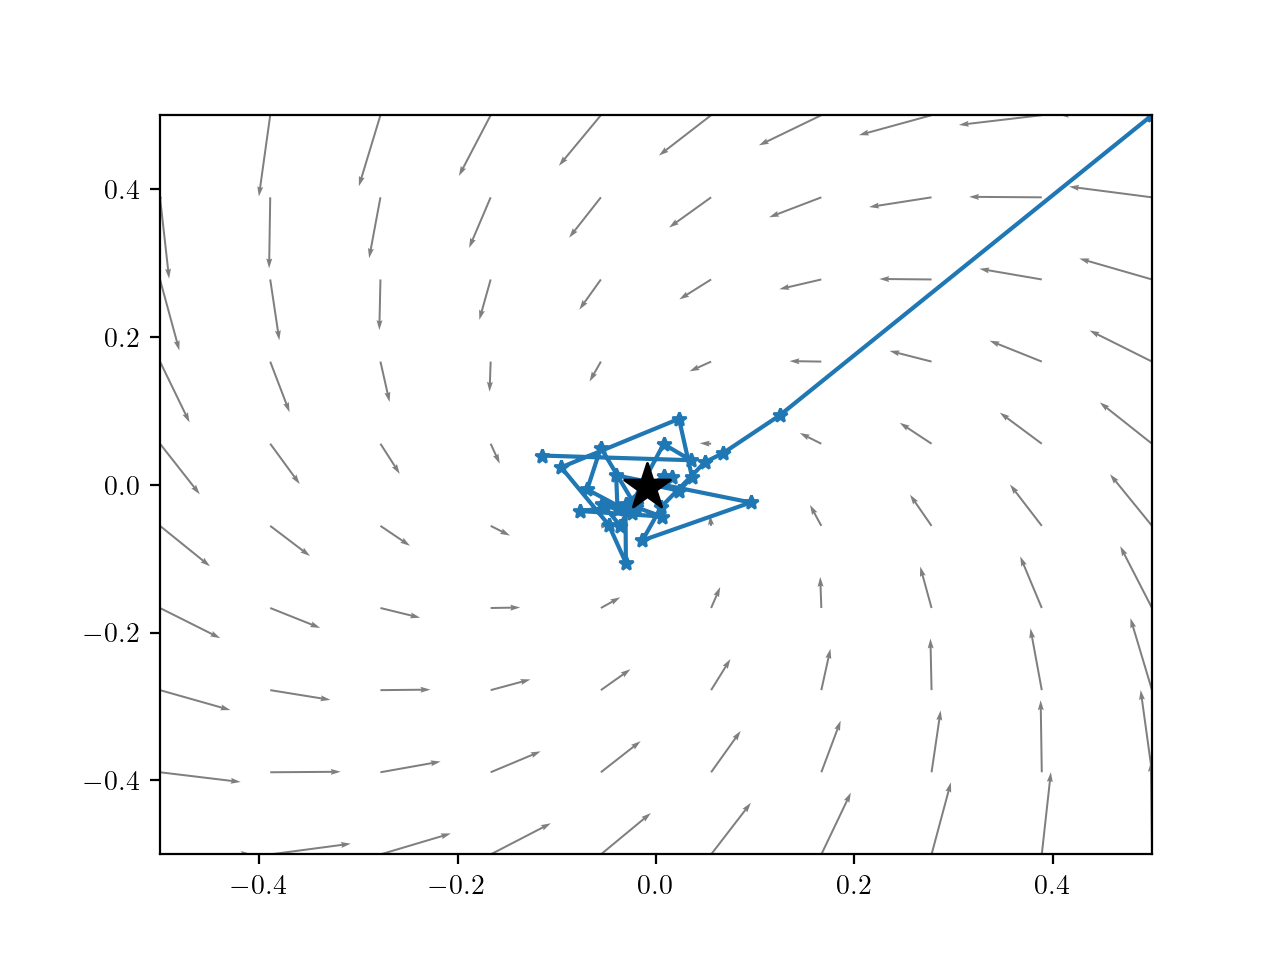

In [3]:
dim = 1
game = QuadraticGame(dim, 100, mu=1, L=1, mu_B=1, L_B=1, bias=True, normal=False, init_func=init_func)
print(game.mu, game.ell, game.mu_H, game.L_H)
fig = plt.figure()
grid = ((-0.5, 0.5), (-0.5, 0.5))
plot_grad(game, grid=grid)

In [4]:
lr_H = 1/(2*game.L_H)
alg = ConsensusOptimization(game, lr=0, lr_H=lr_H, full_batch=False, save_trajectory=True)
results = alg.run(30, seed=123456)
trajectory = np.array(results["x"])
plt.plot(trajectory[:,0], trajectory[:,1], marker="*", label="SHGD", markersize=5)

In [29]:
lr = 1/(2*game.ell)
alg = ConsensusOptimization(game, lr=lr, lr_H=0, full_batch=False, save_trajectory=True)
results = alg.run(30, seed=123456)
trajectory = np.array(results["x"])
plt.plot(trajectory[:,0], trajectory[:,1], marker="o", label="SGDA", markersize=5)

In [30]:
lr = 1/(4*game.ell)
lr_H = 1/(4*game.L_H)
alg = ConsensusOptimization(game, lr=lr, lr_H=lr_H, full_batch=False, save_trajectory=True)
results = alg.run(30, seed=123456)
trajectory = np.array(results["x"])
plt.plot(trajectory[:,0], trajectory[:,1], marker=">", label="SCO", markersize=5)

In [264]:
plt.xlabel(r"$x_0$")
plt.ylabel(r"$x_1$")
plt.legend(loc="lower right")
plt.savefig("figures/2d_small.pdf", format='pdf', bbox_inches='tight')

## Large $\kappa_G$

0.20000000298023224 5.199999809265137 1.0198038816452026 1.0198038816452026


/private/home/hberard/.conda/envs/dev/lib/python3.7/site-packages/torch/nn/modules/container.py:434: UserWarning: Setting attributes on ParameterList is not supported.
  warnings.warn("Setting attributes on ParameterList is not supported.")


<IPython.core.display.Javascript object>


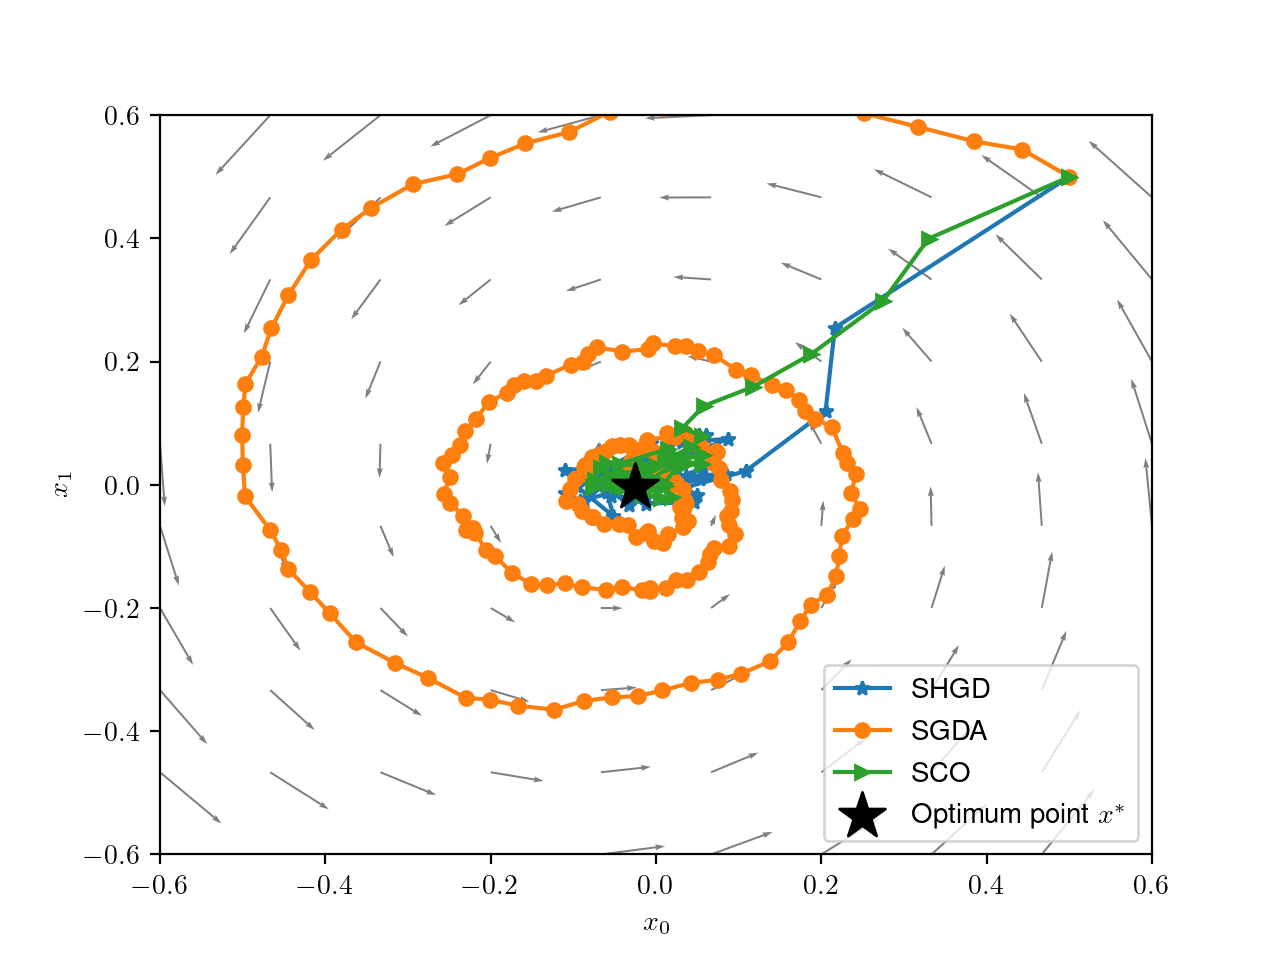

In [271]:
dim = 1
game = QuadraticGame(dim, 100, mu=2e-1, L=2e-1, mu_B=1, L_B=1, bias=True, normal=False, init_func=init_func)
print(game.mu, game.ell, game.mu_H, game.L_H)
fig = plt.figure()
grid = ((-0.6, 0.6), (-0.6, 0.6))
plot_grad(game, grid=grid)

In [272]:
lr_H = 1/(2*game.L_H)
alg = ConsensusOptimization(game, lr=0, lr_H=lr_H, full_batch=False, save_trajectory=True)
results = alg.run(50)
trajectory = np.array(results["x"])
plt.plot(trajectory[:,0], trajectory[:,1], marker="*", label="SHGD", markersize=5)

In [273]:
lr = 1/(2*game.ell)
alg = ConsensusOptimization(game, lr=lr, lr_H=0, full_batch=False, save_trajectory=True)
results = alg.run(200)
trajectory = np.array(results["x"])
plt.plot(trajectory[:,0], trajectory[:,1], marker="o", label="SGDA", markersize=5)

In [274]:
lr = 1/(4*game.ell)
lr_H = 1/(4*game.L_H)
alg = ConsensusOptimization(game, lr=lr, lr_H=lr_H, full_batch=False, save_trajectory=True)
results = alg.run(50)
trajectory = np.array(results["x"])
plt.plot(trajectory[:,0], trajectory[:,1], marker=">", label="SCO", markersize=5)

In [275]:
plt.xlabel(r"$x_0$")
plt.ylabel(r"$x_1$")
plt.legend(loc="lower right")
plt.savefig("figures/2d_large.pdf", format='pdf', bbox_inches='tight')

In [39]:
print(np.__version__)

1.19.2


In [1]:
import time
import scipy.sparse.linalg
import torch
import numpy

m = torch.zeros(100,100,100).normal_().cuda()
#m1 = m.view(100, 1, 100, 100)
#m2 = m.view(1, 100, 100, 100)
#p = m1

t = time.time()
torch.linalg.eigvalsh(m)
print(time.time() - t)

t = time.time()
torch.linalg.eigvalsh(m.cpu())
print(time.time() - t)

t = time.time()
scipy.sparse.linalg.eigsh(m.cpu().numpy(), k=1, return_eigenvectors=False)
print(time.time() - t)

t = time.time()
scipy.linalg.eigvalsh(m.cpu().numpy(), subset_by_index=[100-1, 100-1])
print(time.time() - t)

t = time.time()
numpy.linalg.eigvalsh(m.cpu().numpy())
print(time.time() - t)


0.47233033180236816
0.027269840240478516


AttributeError: module 'scipy' has no attribute 'sparse'

In [1]:
import scipy

In [3]:
scipy.__version__

AttributeError: module 'scipy' has no attribute '__version__'

In [12]:
from enum import Enum
import argparse

class Attacker(Enum):
    PGD = 'pgd'
    FGSM = 'fgsm'
    LANGEVIN = 'langevin'

    @classmethod
    def add_arguments(cls, parser=None):
        if parser is None:
            parser = argparse.ArgumentParser()

        parser.add_argument('--attacker_type', default=cls.LANGEVIN, type=cls, choices=cls)
        
        return parser


usage: ipykernel_launcher.py [-h] [--attacker_type {Attacker.PGD,Attacker.FGSM,Attacker.LANGEVIN}]
ipykernel_launcher.py: error: argument --attacker_type: invalid Attacker value: 'PGD'
ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/private/home/hberard/.conda/envs/dev-new/lib/python3.8/argparse.py", line 2422, in _get_value
    result = type_func(arg_string)
  File "/private/home/hberard/.conda/envs/dev-new/lib/python3.8/enum.py", line 339, in __call__
    return cls.__new__(cls, value)
  File "/private/home/hberard/.conda/envs/dev-new/lib/python3.8/enum.py", line 663, in __new__
    raise ve_exc
ValueError: 'PGD' is not a valid Attacker

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/private/home/hberard/.conda/envs/dev-new/lib/python3.8/argparse.py", line 1800, in parse_known_args
    namespace, args = self._parse_known_args(args, namespace)
  File "/private/home/hberard/.conda/envs/dev-new/lib/python3.8/argparse.py", line 2006, in _parse_known_args
    start_index = consume_optional(start_index)
  File "/private/home/hberard/.conda/envs/dev-new/lib/python3.8/argparse.py", line 1946, in consume_optional

TypeError: object of type 'NoneType' has no len()

In [27]:
import importlib
slurm = importlib.util.find_spec("submitit") is not None

In [28]:
slurm

True

In [23]:
submitit.

SyntaxError: invalid syntax (<ipython-input-23-65a6751713b3>, line 1)